# Prediciting a full-sized synthetic image
#### Ross Carmichael
#### 19/10/21

In [166]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing 

import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

from sklearn.preprocessing import LabelEncoder

from IPython.display import clear_output
import matplotlib.pyplot as plt

from glob import glob
import os
import numpy as np
import cv2
from MightyMosaic import MightyMosaic

In [5]:
model = tf.keras.models.load_model('saved_model/model_1.3_50_epochs')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 64, 64, 96), 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 512)    1476608     model[0][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 8, 1088)   0           sequential[0][0]                 
                                                                 model[0][3]                

## Load in some images to be segmented

In [175]:
def load_data(path:
    images = sorted(glob(os.path.join(path, "*.png")))
    return images

def read_image(path):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    #image = cv2.resize(image, (128, 128))
    image = image / 255.0
    image = image.astype(np.float32)
    #image = np.expand_dims(image, axis=0)

    return image

In [176]:
path = "./full-size/synthetic/"

# File paths
images = load_data(path)
print(f"Images: {len(image_paths)}")

synthetic_images = [read_image(image) for image in images]
print(synthetic_images[0].shape)

Images: 6
(512, 512, 3)


In [231]:
path = "./training_images/33_particles9.png"
image = read_image(path)
image = np.expand_dims(image, axis=0)

pred = model.predict(image)

## Split the full-sized images into mosaics and predict

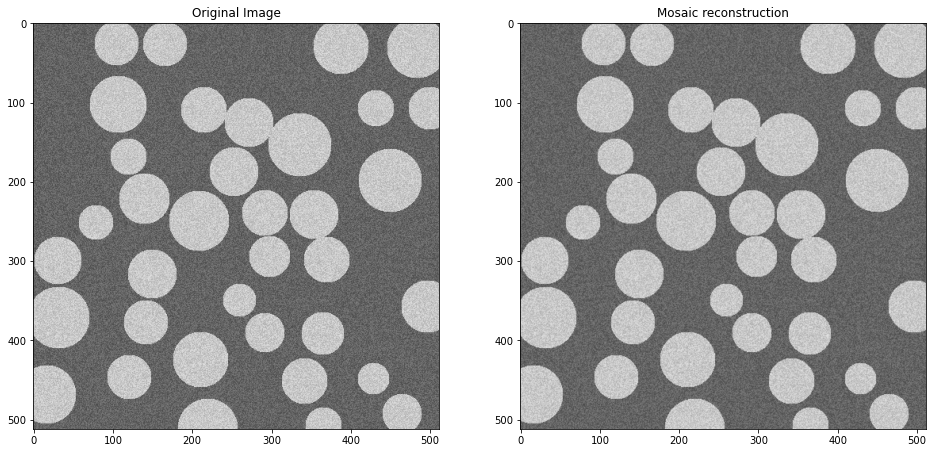

Mosaic shape: (16, 16, 128, 128, 3)


In [256]:
mosaic = MightyMosaic.from_array(synthetic_images[0], (128,128), overlap_factor=4, fill_mode='reflect')
plt.figure(figsize=(16,16))
plt.subplot(121)
plt.title("Original Image")
plt.imshow(synthetic_images[0])
plt.subplot(122)
plt.title("Mosaic reconstruction")
plt.imshow(mosaic.get_fusion(), interpolation='bilinear', vmin=0, vmax=1)
plt.show()
print("Mosaic shape: " + str(mosaic.shape))

In [257]:
prediction = mosaic.apply(model.predict, progress_bar=True)

In [258]:
fused_prediction = prediction.get_fusion()
labels = np.argmax(fused_prediction, axis=-1)

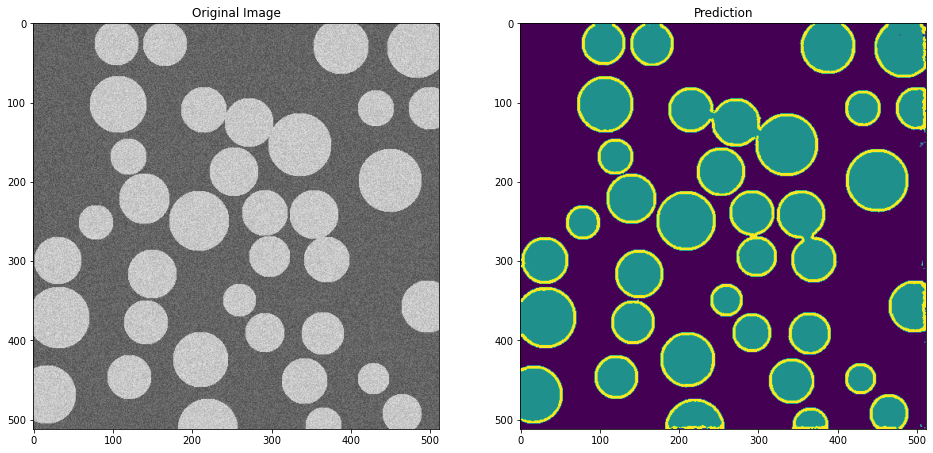

In [259]:
plt.figure(figsize=(16,16))
plt.subplot(121)
plt.title("Original Image")
plt.imshow(synthetic_images[0])

plt.subplot(122)
plt.title("Prediction")
plt.imshow(labels, interpolation='bilinear')
plt.show()